# Model comparisons
This notebook allows for comparisons to different inputs such as the phase space factors and nuclear models to see their impact on the shapes

### Imports

In [50]:
import sys
sys.path.append("/Users/mistryk2/Packages/nudobe/src/")
sys.path.append("/Users/mistryk2/Packages/nudobe/")

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from nudobe import EFT
from EFT import LEFT

from nudobe import constants, functions
from constants import *

#import neutrino mixing matrix function
from functions import U_PMNS

#import multiprocessing

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import time

import matplotlib.cm as cm


### Setup mLRSM

In [51]:
def get_masses(m_min           = 0, 
                ordering        = "NO", 
                Majorana_phases = [0,0], 
                v_R             = 10*TeV, 
                v_L             = 0.1*eV, 
                m_heavy         = np.array([10,12,13])*TeV,
                theta_L         = 0,
               ):
    U = U_PMNS(alpha=Majorana_phases)
    m = m_min
    
    if ordering == "NO" or ordering == "NH":
        m1 = m
        m2 = np.sqrt(m1**2+m21)
        m3 = np.sqrt(m2**2+m32)
    elif ordering == "IO" or ordering == "IH":
        m3 = m
        m2 = np.sqrt(m3**2-m32IO)
        m1 = np.sqrt(m2**2-m21)

    
    #diagonal light neutrino masses
    m_nu = np.diag([m1,m2,m3])*1e-9
    
    #diagonal heavy neutrino masses
    m_nu_R = np.diag(m_heavy)
    
    #non-diagonal light neutrino mass
    M_nu = U@m_nu@U.T
    
    #non-diagonal heavy neutrino mass
    M_nu_R = U@m_nu_R@U.T
    
    #inverse matrices
    M_nu_R_inv = np.linalg.inv(M_nu_R)
    
    M_nu_R_dagger_inv = np.linalg.inv(M_nu_R.T.conjugate())
    
    #non-diagonal yukawa matrices
    M_R = M_nu_R.T.conjugate()/(np.sqrt(2)*v_R)
    M_L = M_R.T.conjugate()
    
    M_nu_L = (np.sqrt(2) * v_L * np.exp(1j*theta_L) * M_L)
    
    #get the dirac yukawa matrix eq.57
    M_nu_D = U@m_nu_R@scipy.linalg.sqrtm(v_L/v_R*np.exp(1j*theta_L) * np.diag([1,1,1])
                                                          - np.linalg.inv(m_nu_R)@m_nu+0j)@U.T
    #return results
    return(m_nu, m_nu_R, M_nu_R, M_nu_R_inv, M_nu_R_dagger_inv, M_nu_D, M_nu_L)


# Gets the Wilson Coeficients at SMEFT
def GetWCs(m_min, v_R, v_L, m_heavy, theta_L, xi):
      m_nu, m_nu_R, M_nu_R, M_nu_R_inv, M_nu_R_dagger_inv, M_nu_D, M_nu_L = get_masses(
                                                                                    m_min           = 0, 
                                                                                    ordering        = "NO", 
                                                                                    Majorana_phases = [0,0], 
                                                                                    v_R             = v_R, 
                                                                                    v_L             = v_L, 
                                                                                    m_heavy         = m_heavy,
                                                                                    theta_L         = theta_L,
                                                                                    )


      # SMEFT
      C5         = 1/vev**2 * (M_nu_D.T@M_nu_R_inv@M_nu_D-M_nu_L)[0,0]
      C_LeudPhi7 = np.sqrt(2)/vev * (1/v_R**2 *(V_ud_R.conjugate()) * M_nu_D.T@M_nu_R_inv)[0,0]
      C_LPhiDe7  = 2j * xi*np.exp(1j * alpha) / (1 + xi**2) * C_LeudPhi7 / V_ud_R.conjugate()
      C_eeud9    = 0.88 * (-1 / (2 * v_R**4) * V_ud_R**2 * (M_nu_R_dagger_inv + 2 / m_DR**2 * M_nu_R))[0,0]
      C_eePhiud9 = -4 * (xi * np.exp(-1j * alpha)) / (1 + xi**2) * C_eeud9/V_ud_R
      C_eePhiD9  = 4 * xi**2 * np.exp(-2j * alpha) / ((1 + xi**2)**2) * C_eeud9/V_ud_R**2

      return {"LH(5)"      : C5, 
            "LeudH(7)"   : C_LeudPhi7, 
            "LHDe(7)"    : C_LPhiDe7, 
            "ddueue(9)"  : 4*np.conj(C_eeud9), 
            "deueH2D(9)" : -2 * np.conj(C_eePhiud9), 
            "eeH4D2(9)"  : -np.conj(C_eePhiD9)
            }

# Matches SMEFT wilson coeficients down to m_W scale using Table in Appendix A and Matching scheme in Appendix B
def GetWCsLEFT(m_min, v_R, v_L, m_heavy, theta_L, xi):
      SMEFT_WCs = GetWCs(0, v_R, v_L, m_heavy, theta_L, xi)

      m_bb   = -vev**2 * SMEFT_WCs["LH(5)"]
      C_VR6  = (vev**3/np.sqrt(2)) * SMEFT_WCs["LeudH(7)"].conjugate()
      C_VL6  = - (vev**3 * 1j) /np.sqrt(2) *V_ud * SMEFT_WCs["LHDe(7)"].conjugate()
      C_1R9p = - (vev**5 / 4) *  SMEFT_WCs["ddueue(9)"].conjugate()
      C_4R9  = -vev**5 * (V_ud/2) * SMEFT_WCs["deueH2D(9)"].conjugate()
      C_1R9  = -vev**5 * (V_ud/2) * SMEFT_WCs["eeH4D2(9)"].conjugate()

      return {
            "m_bb"       : m_bb,
            "VR(6)"      : C_VR6,
            "VL(6)"      : C_VL6,
            "1R(9)prime" : C_1R9p,
            "4R(9)"      : C_4R9,
            "1R(9)"      : C_1R9
      }

def get_WCs_leptoquark(alpha_SL  = 0,
            alpha_VL  = 0,
            alpha_SR  = 0,
            alpha_VR  = 0,
            epsilon_S = 0,
            epsilon_V = 0, 
            M_V       = 1*TeV, 
            M_S       = 1*TeV
           ):
    WC_LQ = {}
    
    #see arXiv: hep-ph/9603213 for the definition of eps_I, alpha_I
    WC_LQ["SL(6)"] =  1/(G_F*np.sqrt(2)) * epsilon_V/(M_V**2)
    WC_LQ["SR(6)"] =  1/(G_F*np.sqrt(2)) * epsilon_S/(M_S**2)
    WC_LQ["VL(6)"] = +1/(G_F*np.sqrt(2)) * np.sqrt(2) * (alpha_SL/(M_S**2) + alpha_VL/(M_V**2))
    WC_LQ["VR(6)"] = -1/(G_F*np.sqrt(2)) * (alpha_SR/(M_S**2) + alpha_VR/(M_V**2))

    return(WC_LQ)


In [52]:
#Parameters

# ------- mLRSM ---------
#masses
v_R  = 10*TeV
v_L  = 0.1*eV
m_DR = 4*TeV

#heavy neutrino masses
m_heavy = np.array([10,12,13])*TeV

#mixings
V_ud_R  = V_ud
V_ud_L  = V_ud
xi      = m_b/m_t
theta_L = 0
alpha   = 0

# ------- Leptoquark ---------
M_V       = 1*TeV 
M_S       = 1*TeV
alpha_SL  = 1.81e-8*(M_S/1*TeV)**2
alpha_VL  = 1.81e-8*(M_S/1*TeV)**2
alpha_SR  = 1.86e-6*(M_S/1*TeV)**2
alpha_VR  = 1.86e-6*(M_S/1*TeV)**2
epsilon_S = 5.8e-9*(M_S/1*TeV)**2
epsilon_V = 5.8e-9*(M_V/1*TeV)**2


nbins = 100
eps = 1e-5 #avoid poles
nevts = 100000

Q = 2.457984 # Q-value in MeV units
me = 0.51099895 # electron mass in MeV units


# Get the Dark2 colormap
cmap = cm.get_cmap('Dark2')

# Define nu_L and xi for each model
# mLRSM models
# Model = {"v_L":0.1*eV, "xi": m_b/m_t}
# Model = {"v_L":0.1*eV, "xi": 0}
Model = {"v_L":100*eV, "xi": m_b/m_t}
# Model = {"v_L":100*eV, "xi": 0}


# NMEs
NMEs = []
NMEs.append("SM")
NMEs.append("IBM2")
NMEs.append("QRPA")

# PSFs
PSFs = []
PSFs.append("A")
PSFs.append("B")

# Decide to use the low energy constants
useLEC = False

# Mode
# Mode = "mlrsm"
# Mode = "mbb"
Mode = "leptoquark"

Models = []

names = []

for psf in PSFs:
      for nme in NMEs:
            
            if (Mode == "mbb"):
                  Models.append(EFT.LEFT({"m_bb" : 28*meV}, name = f"mbb {nme} {psf}", method = nme, PSF_scheme = psf))
                  names.append(f"mbb {nme} {psf}")
            elif(Mode == "mlrsm"):
                  Models.append( EFT.LEFT(GetWCsLEFT(0, v_R, Model["v_L"], m_heavy, theta_L, Model["xi"]), name = f"mLRSM {nme} {psf}", method = nme, PSF_scheme = psf))
                  names.append( f"mLRSM {nme} {psf}")
            elif(Mode == "leptoquark"):
                  Models.append( EFT.LEFT(get_WCs_leptoquark(alpha_SL, alpha_VL, alpha_SR, alpha_VR, epsilon_S, epsilon_V, M_V, M_S), name = f"LeptoQ {nme} {psf}", method = nme, PSF_scheme = psf))
                  names.append( f"Leptoquark {nme} {psf}")


In [53]:
# Set the model
model = Models[2]

for WC in model.WC:
    if model.WC[WC] != 0:
        print(WC, model.WC[WC])

model.t_half("136Xe")

SL(6) 528.5372214162422
SR(6) 528.5372214162422
VL(6) 3103.623205739268
VR(6) -225521.71314633547


9.90481693017729

### First, sampling of electron kinetic energies

In [54]:
# Calculate momentum from kinetic energy
def p_fun(t): # valid for both e1 and e2
    p = np.sqrt(t*(t+2.*me))
    return p

In [55]:
# Define normalized energy array
ebar_vec = np.linspace(0+eps, 1-eps, nbins)

# Define array of electron kinetic energies and electron momenta
# ebar = (E_e - m_e)/Q = T_e/Q -> T_e = ebar*Q
t_vec = ebar_vec*Q
#print(t_vec)
p_vec = p_fun(t_vec)

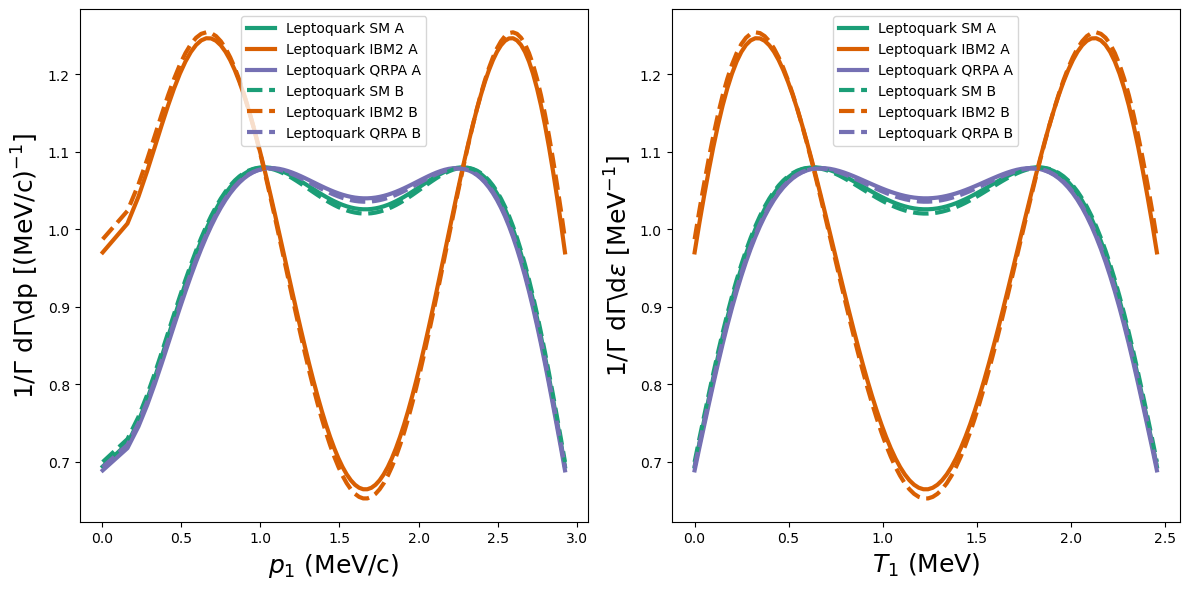

In [56]:
fig = plt.figure(figsize=(12, 6))


cols = [cmap(i) for i in range(3)]
cols = cols+cols

# cols =["darkgreen","darkblue","darkred","darkgreen","darkblue","darkred"]

for m in range(len(Models)):

    rho_spec_vec = Models[m].spectrum(ebar_vec,isotope="136Xe")

    if (m <3):
        linestyle="-"
    else:
        linestyle="--"

    plt.subplot(121)
    plt.plot(p_vec, rho_spec_vec/sum(rho_spec_vec)*nbins, linewidth=3,label = names[m],linestyle=linestyle,color=cols[m])
    plt.xlabel(r'$p_1$ (MeV/c)', fontsize=18)
    plt.ylabel("1/$\Gamma$ d$\Gamma$\dp [(MeV/c)$^{-1}$]", fontsize=18)
    plt.legend()

    plt.subplot(122)
    plt.plot(t_vec, rho_spec_vec/sum(rho_spec_vec)*nbins, linewidth=3,label = names[m],linestyle=linestyle,color=cols[m])
    plt.xlabel(r'$T_1$ (MeV)', fontsize=18)
    plt.ylabel("1/$\Gamma$ d$\Gamma$\d$\epsilon$ [MeV$^{-1}$]", fontsize=18)
    plt.legend()

    plt.tight_layout()
    

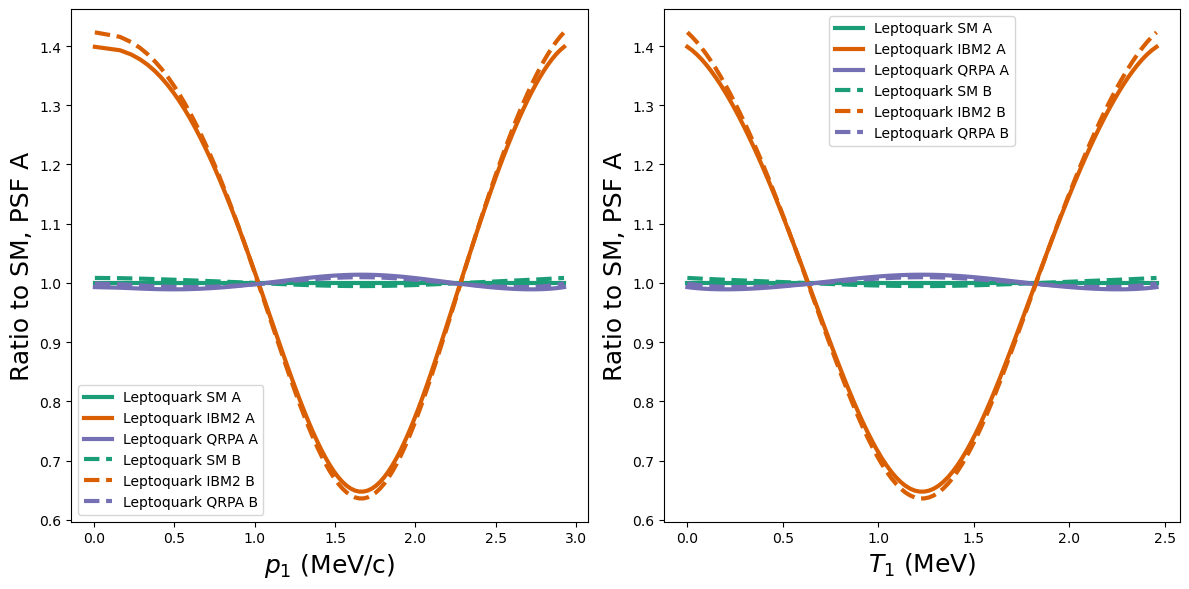

In [57]:
# Plot the ratio with respect to PSF A and SM

fig = plt.figure(figsize=(12, 6))

default_model = 0

for m in range(len(Models)):

    rho_spec_vec = Models[m].spectrum(ebar_vec,isotope="136Xe")
    rho_spec_vec = rho_spec_vec/sum(rho_spec_vec)*nbins

    if (m == 0):
        default_model = rho_spec_vec

    if (m <3):
        linestyle="-"
    else:
        linestyle="--"

    plt.subplot(121)
    plt.plot(p_vec, rho_spec_vec/default_model, linewidth=3,label = names[m], linestyle=linestyle, color=cols[m])
    plt.xlabel(r'$p_1$ (MeV/c)', fontsize=18)
    plt.ylabel("Ratio to SM, PSF A", fontsize=18)
    plt.legend()

    plt.subplot(122)
    plt.plot(t_vec, rho_spec_vec/default_model, linewidth=3,label = names[m], linestyle=linestyle, color=cols[m])
    plt.xlabel(r'$T_1$ (MeV)', fontsize=18)
    plt.ylabel("Ratio to SM, PSF A", fontsize=18)
    plt.legend()

    plt.tight_layout()


### Second, sampling of electron angular distributions

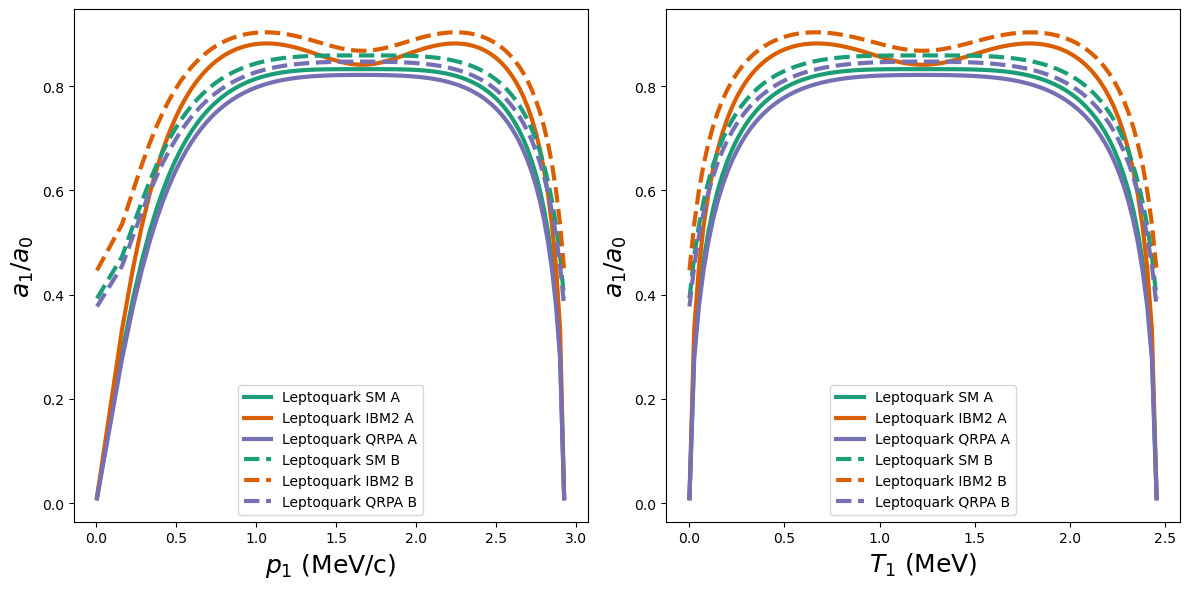

In [58]:
fig = plt.figure(figsize=(12, 6))


for m in range(len(Models)):

    rho_angle_vec = Models[m].angular_corr(ebar_vec,isotope="136Xe")

    if (m <3):
        linestyle="-"
    else:
        linestyle="--"

    plt.subplot(121)
    plt.plot(p_vec, rho_angle_vec, linewidth=3,label = names[m],linestyle=linestyle,color=cols[m])
    plt.xlabel(r'$p_1$ (MeV/c)', fontsize=18)
    plt.ylabel("$a_1/a_0$", fontsize=18)
    plt.legend()

    plt.subplot(122)
    plt.plot(t_vec, rho_angle_vec, linewidth=3,label = names[m],linestyle=linestyle,color=cols[m])
    plt.xlabel(r'$T_1$ (MeV)', fontsize=18)
    plt.ylabel("$a_1/a_0$", fontsize=18)
    plt.legend()

    plt.tight_layout()

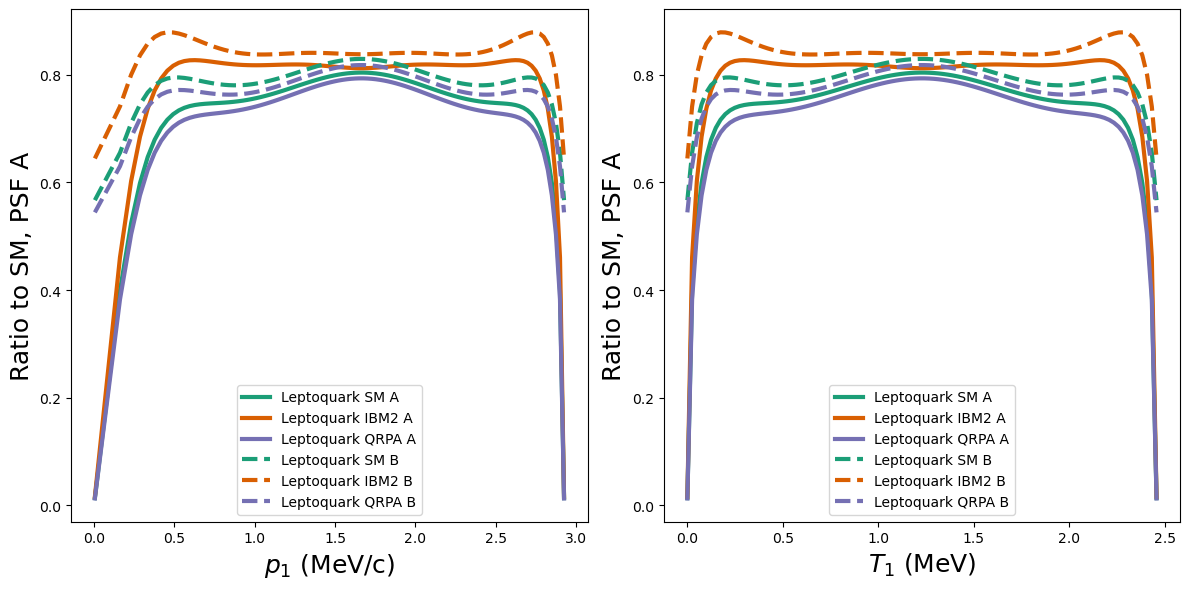

In [59]:
fig = plt.figure(figsize=(12, 6))

default_model = 0

for m in range(len(Models)):

    rho_angle_vec = Models[m].angular_corr(ebar_vec,isotope="136Xe")

    if (m == 0):
        default_model = rho_spec_vec

    if (m <3):
        linestyle="-"
    else:
        linestyle="--"

    plt.subplot(121)
    plt.plot(p_vec, rho_angle_vec/default_model, linewidth=3,label = names[m],linestyle=linestyle,color=cols[m])
    plt.xlabel(r'$p_1$ (MeV/c)', fontsize=18)
    plt.ylabel("Ratio to SM, PSF A", fontsize=18)
    plt.legend()

    plt.subplot(122)
    plt.plot(t_vec, rho_angle_vec/default_model, linewidth=3,label = names[m],linestyle=linestyle,color=cols[m])
    plt.xlabel(r'$T_1$ (MeV)', fontsize=18)
    plt.ylabel("Ratio to SM, PSF A", fontsize=18)
    plt.legend()

    plt.tight_layout()